In [1]:
import os
import json
from birdlib import utils
import torch

# Istogrammi

In [30]:
TRAIN_PATH = '/home/giacomoschiavo/segments/dataset/train'
TEST_PATH = '/home/giacomoschiavo/segments/dataset/test'

train_count = {}
test_count = {}
for species in os.listdir(TRAIN_PATH):
    train_count[species.split("_")[0]] = len(os.listdir(os.path.join(TRAIN_PATH, species)))
    test_count[species.split("_")[0]] = len(os.listdir(os.path.join(TEST_PATH, species)))

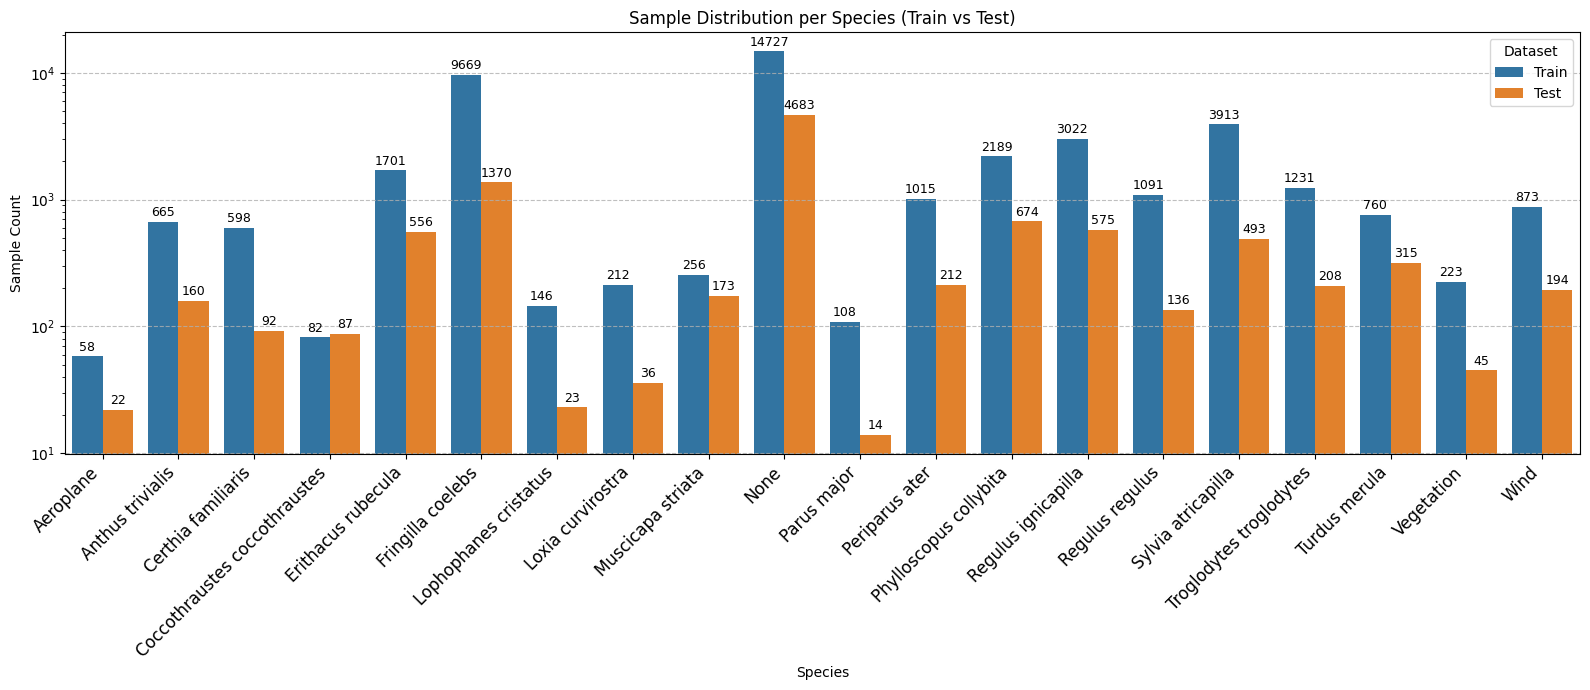

In [36]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Merge the two dictionaries into a unified list
all_species = sorted(set(train_count.keys()) | set(test_count.keys()))
data = []

for species in all_species:
    train = train_count.get(species, 0)
    test = test_count.get(species, 0)
    data.append({
        'Species': species,
        'Train': train,
        'Test': test
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars='Species', value_vars=['Train', 'Test'],
                    var_name='Dataset', value_name='Sample Count')

# Plot
plt.figure(figsize=(16, 7))
ax = sns.barplot(x='Species', y='Sample Count', hue='Dataset', data=df_melted)
plt.yscale('log')  # Log scale to handle large range
plt.grid(True, axis='y', linestyle='--', alpha=0.8)  # Add horizontal grid lines

# Add sample counts above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, rotation=0, padding=2)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Sample Distribution per Species (Train vs Test)")
plt.tight_layout()
plt.show()


In [2]:
with open('/home/giacomoschiavo/finetuning-BirdNET/utils/dataset/dataset_config_augm_final.json') as f:
    dataset_config = json.load(f)

In [5]:
TRAIN_PATH = '/home/giacomoschiavo/segments/dataset/train'

In [6]:
def compute_pos_weights(label_counts: dict, class_order: list, n_samples: int, device='cpu'):
    weights = []
    for cls in class_order:
        pos = label_counts[cls]
        neg = n_samples - pos
        w = neg / pos if pos > 0 else 1.0  # evita divisione per zero
        weights.append(w)
    return torch.tensor(weights, dtype=torch.float32).to(device)


In [7]:
# Esempio fittizio
label_counts = { species: len(os.listdir(os.path.join(TRAIN_PATH, species))) for species in os.listdir(TRAIN_PATH)}
counts = torch.tensor(list(label_counts.values()), dtype=torch.float32)
inv_freq = 1.0 / (counts + 1e-6)
pos_weight = inv_freq / inv_freq.mean()  # normalize around 1
names = list(label_counts.keys())
importance_map = {
    'Aeroplane': 0.1,
    'Wind': 0.1,
    'Vegetation': 0.1,
    'None': 0.0,
    # fallback = 1.0
}

importance = torch.tensor([importance_map.get(name, 1.0) for name in names])
final_pos_weight = pos_weight * importance + 1e-3

final_pos_weight, pos_weight, names
for i, name in enumerate(names):
    print(name, final_pos_weight[i])

Aeroplane tensor(0.5022)
Muscicapa striata_Spotted Flycatcher tensor(1.1364)
Periparus ater_Coal Tit tensor(0.2874)
Regulus regulus_Goldcrest tensor(0.2674)
Anthus trivialis_Tree Pipit tensor(0.4381)
Vegetation tensor(0.1313)
Troglodytes troglodytes_Eurasian Wren tensor(0.2371)
Erithacus rubecula_European Robin tensor(0.1719)
None tensor(0.0010)
Parus major_Great Tit tensor(2.6924)
Certhia familiaris_Eurasian Treecreeper tensor(0.4871)
Phylloscopus collybita_Common Chiffchaff tensor(0.1338)
Coccothraustes coccothraustes_Hawfinch tensor(3.5458)
Wind tensor(0.0343)
Turdus merula_Eurasian Blackbird tensor(0.3835)
Loxia curvirostra_Common Crossbill tensor(1.3721)
Regulus ignicapilla_Common Firecrest tensor(0.0972)
Sylvia atricapilla_Eurasian Blackcap tensor(0.0753)
Lophophanes cristatus_Crested Tit tensor(1.9919)
Fringilla coelebs_Common Chaffinch tensor(0.0311)


In [8]:
# tra tutti i file, trova il min e max 'sampling_rate' e 'duration'
min_duration = float('inf')
max_duration = float('-inf')
min_sampling_rate = float('inf')
max_sampling_rate = float('-inf')
count = {}
audio_infos = ['audio_info.json', 'audio_info_2.json', 'audio_info_test.json']
for audio_info in audio_infos:
    with open(f'utils/{audio_info}', 'r') as f:
        data = json.load(f)
        for item in data:
            sampling_rate = data[item]['sampling_rate'] 
            if sampling_rate not in count:
                count[sampling_rate] = 0
            count[sampling_rate] += 1
            sampling_rate = data[item]['sampling_rate']
            duration = data[item]['duration']
            if sampling_rate < min_sampling_rate:
                min_sampling_rate = sampling_rate
            if sampling_rate > max_sampling_rate:
                max_sampling_rate = sampling_rate
            if duration < min_duration:
                min_duration = duration
            if duration > max_duration:
                max_duration = duration
print(f"Min sampling rate: {min_sampling_rate}")    
print(f"Max sampling rate: {max_sampling_rate}")
print(f"Min duration: {min_duration}")
print(f"Max duration: {max_duration}")


Min sampling rate: 22050
Max sampling rate: 48000
Min duration: 2.815419501133787
Max duration: 600.0


# Esempio Wind con Sylvia atricapilla_Eurasian Blackcap

<audio controls src="../segments/dataset/test/Wind/20190601_100000_3_0.wav" title="Title"></audio>

Shape dello spettrogramma: torch.Size([256, 256])


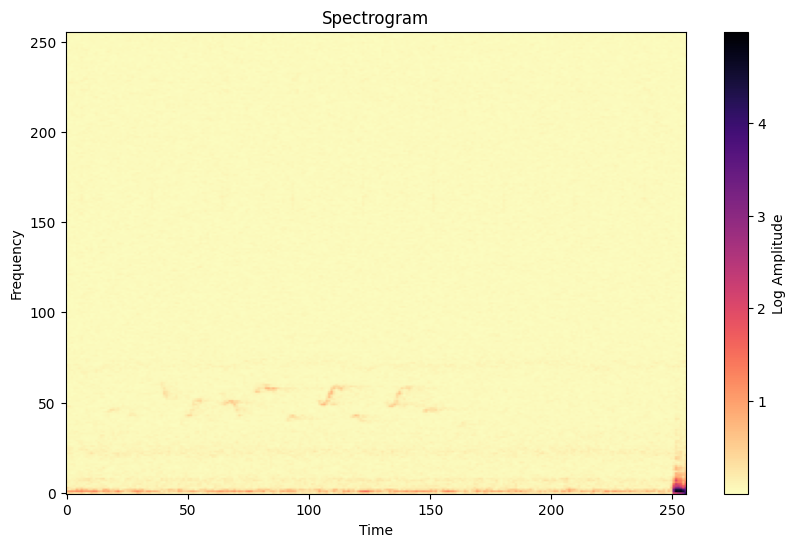

In [10]:
import torch
import matplotlib.pyplot as plt

# Carica lo spettrogramma
spectrogram = torch.load("/home/giacomoschiavo/segments/dataset/test_specs/Sylvia atricapilla_Eurasian Blackcap/20190601_100000_3_0.pt")

print(f"Shape dello spettrogramma: {spectrogram.shape}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.numpy(), origin="lower", aspect="auto", cmap="magma_r")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Log Amplitude")
plt.show()


In [ ]:
# Eurasian Blackcap	blackc1	0.8474	/home/giacomoschiavo/segments/dataset/test/Sylvia atricapilla_Eurasian Blackcap/20190601_100000_3_0.wav	0
# Common Chiffchaff	comchi1	0.0636	/home/giacomoschiavo/segments/dataset/test/Sylvia atricapilla_Eurasian Blackcap/20190601_100000_3_0.wav	0
# Eurasian Blackcap	blackc1	0.8474	/home/giacomoschiavo/segments/dataset/test/Wind/20190601_100000_3_0.wav	0
# Common Chiffchaff	comchi1	0.0636	/home/giacomoschiavo/segments/dataset/test/Wind/20190601_100000_3_0.wav	0
# "3_0": {
#     "Aeroplane": 0.16630589962005615,
#     "Wind": 0.9989504814147949,
#     "Sylvia atricapilla_Eurasian Blackcap": 1.0
# },


## esempio Erithacus rubecula


<audio controls src="../segments/dataset/test/Fringilla coelebs_Common Chaffinch/20190601_030000_10_5.wav" title="Title"></audio>

Shape dello spettrogramma: torch.Size([256, 256])


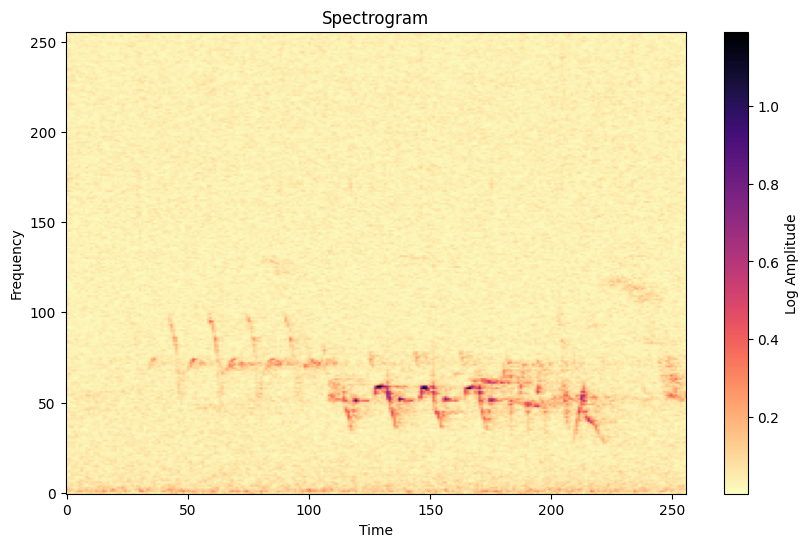

In [41]:
import torch
import matplotlib.pyplot as plt

# Carica lo spettrogramma
spectrogram = torch.load("/home/giacomoschiavo/segments/dataset/test_specs/Fringilla coelebs_Common Chaffinch/20190601_030000_7_5.pt")

print(f"Shape dello spettrogramma: {spectrogram.shape}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.numpy(), origin="lower", aspect="auto", cmap="magma_r")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Log Amplitude")
plt.show()


Identificano molto bene l'erithacus ma entramni saltano la fringilla completamente
European Robin	eurrob1	0.9638	/home/giacomoschiavo/segments/dataset/test/Fringilla coelebs_Common Chaffinch/20190601_030000_10_5.wav
"10_5": {
"Erithacus rubecula_European Robin": 0.999411940574646
},


In [ ]:
# I
# European Robin	eurrob1	0.9638	/home/giacomoschiavo/segments/dataset/test/Fringilla coelebs_Common Chaffinch/20190601_030000_10_5.wav


['1',
 '10',
 '100',
 '1000',
 '10000',
 '10001',
 '10002',
 '10003',
 '10004',
 '10005',
 '10006',
 '10007',
 '10008',
 '10009',
 '1001',
 '10010',
 '10011',
 '10012',
 '10013',
 '10014',
 '10015',
 '10016',
 '10017',
 '10018',
 '10019',
 '1002',
 '10020',
 '10021',
 '10022',
 '10023',
 '10024',
 '10025',
 '10026',
 '10027',
 '10028',
 '10029',
 '1003',
 '10030',
 '10031',
 '10032',
 '10033',
 '10034',
 '10035',
 '10036',
 '10037',
 '10038',
 '10039',
 '1004',
 '10040',
 '10041',
 '10042',
 '10043',
 '10044',
 '10045',
 '10046',
 '10047',
 '10048',
 '10049',
 '1005',
 '10050',
 '10051',
 '10052',
 '10053',
 '10054',
 '10055',
 '10056',
 '10057',
 '10058',
 '10059',
 '1006',
 '10060',
 '10061',
 '10062',
 '10063',
 '10064',
 '10065',
 '10066',
 '10067',
 '10068',
 '10069',
 '1007',
 '10070',
 '10071',
 '10072',
 '10073',
 '10074',
 '10075',
 '10076',
 '10077',
 '10078',
 '10079',
 '1008',
 '10080',
 '10081',
 '10082',
 '10083',
 '10084',
 '10085',
 '10086',
 '10087',
 '10088',
 '10089'

# Remove augmented spectrograms

In [ ]:
import os
train_specs = '/home/giacomoschiavo/segments/dataset/train_specs'
target_path = '/home/giacomoschiavo/segments/dataset/train_specs_removed'
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_specs):
    for audio in os.listdir(os.path.join(train_specs, species)):
        if 'specaug' in audio:
            os.makedirs(os.path.join(target_path, species), exist_ok=True)
            os.rename(
                os.path.join(train_specs, species, audio),
                os.path.join(target_path, species, audio),
            )